In [1]:
import os, zipfile
from zipfile import ZipFile
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from preprocessing import SelectMajorCategories, CycleEncoder
from visualizations import *
from language import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Montando o setup do Kaggle

In [2]:
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"
    on_colab = True
    ! pip install kaggle --upgrade
else:
    os.environ['KAGGLE_CONFIG_DIR'] = "../../Kaggle/"
    on_colab = False

In [3]:
# Downloading and extracting the data from Kaggle
if on_colab:
    dataset_folder = "./"
    ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis
    ! unzip -q i2a2-nlp-2021-sentiment-analysis.zip -d "./i2a2-nlp-2021-sentiment-analysis/"
    ! rm i2a2-nlp-2021-sentiment-analysis.zip
else:
    dataset_folder = "C:\\Users\\weldl\\datasets\\i2a2-nlp-2021-sentiment-analysis"
    if not os.path.isdir(dataset_folder):
        ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis -p "C:\\Users\\weldl\\datasets"
        # Create a ZipFile Object and load sample.zip in it
        zip_file = dataset_folder + ".zip"
        with ZipFile(zip_file, 'r') as zipObj:
           # Extract all the contents of zip file in different directory
           zipObj.extractall(dataset_folder)
        os.remove(zip_file)

In [4]:
df_train = pd.read_csv(os.path.join(dataset_folder, "train.csv"), low_memory=False)
df_test = pd.read_csv(os.path.join(dataset_folder, "test.csv"), low_memory=False)

In [5]:
df_train.columns

Index(['id', 'submission_date', 'review_title', 'review_text', 'reviewer_id',
       'reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
       'product_id', 'product_name', 'product_brand', 'site_category_lv1',
       'site_category_lv2', 'rating'],
      dtype='object')

In [6]:
df_train.head()

,id,submission_date,review_title,review_text,reviewer_id,reviewer_birth_year,reviewer_gender,reviewer_state,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,rating
0,0,2018-02-25 04:59:13,Americanas Nao tem compromisso,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,be7443b1b96702ad4599acbb8a034938c5df15f293ff72...,1981.0,F,PE,126831715,Google Chromecast 2,google,Informática e Acessórios,NaN,1
1,1,2018-03-12 10:13:18,muito bom produto,"Considerando seu custo, é ótimo som com muita ...",75792fad1da46e5ad1d81fd2fd94d6c1b43cacf87fc58d...,1956.0,M,SP,7954368,Caixa Multimidia 2.1 Com Subwoofer 21w Rms Sp-...,NaN,Informática e Acessórios,Periféricos,4
2,2,2018-01-12 17:20:44,Excelente!,Simplesmente é a melhor que já vi... ela é lin...,6793d62bea0e221898b4b47a2a7079be71c22ea0f35610...,1978.0,F,PR,132381765,"Smart TV LED 43"" Samsung 43MU6100 UHD 4K HDR P...",NaN,TV e Home Theater,TV,5
3,3,2018-03-21 18:18:44,Entrega antes do prazo!,Estou muito satisfeita com o produto é a entre...,ca3562dfc623df2e5055a1d33d8bdce778278e26fb65f1...,1986.0,F,RJ,129605351,"Smart TV LED 32"" SEMP TCL L32S4700S HD com Con...",semp tcl,TV e Home Theater,TV,4
4,4,2018-05-16 07:29:48,Muito bonito.,A gaiola é muito bonita. Colorida e grande. Al...,7e80e277a30db3bf89095683bf61d39dd8c933c9c7c8e2...,1976.0,F,PR,19956796,Gaiola Para Hamster 3 Andares Vermelha,NaN,Pet Shop,Roedores,3


In [7]:
df_test.columns

Index(['id', 'submission_date', 'review_title', 'review_text', 'reviewer_id',
       'reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
       'product_id', 'product_name', 'product_brand', 'site_category_lv1',
       'site_category_lv2'],
      dtype='object')

In [8]:
df_test.head()

,id,submission_date,review_title,review_text,reviewer_id,reviewer_birth_year,reviewer_gender,reviewer_state,product_id,product_name,product_brand,site_category_lv1,site_category_lv2
0,0,2018-01-08 07:06:12,Muito bom equipamento!,"Recebi antes do programado, produto muito bom,...",d52fb901a01d5a94e7d8ff8675de0e97bf7d2dcad6d121...,1971.0,M,DF,119371001,Kit Aparador de Pelos Philips Multigroom QG333...,philips,Beleza e Perfumaria,Barbearia
1,1,2018-03-17 21:28:32,"Amei a estante, a cor é maravilhosa, atendeu a...","Só não é melhor, por este produto não ter pés,...",bbcb7b45aee2aeddcb39aa735284ed168916d7157a254e...,1968.0,F,DF,12637385,Estante Home Theater Para Tv De Até 55 Dimas A...,NaN,Móveis,"Rack, Estante e Painel"
2,2,2018-01-19 10:03:48,Bom!!,"O vidro é um pouco embaçado, mas como estava n...",b37a50e2b164666b485932252805bf66e95b092c98a294...,NaN,F,RJ,124845531,Conjunto de Potes Vidro 5 Peças com Tampa Bra...,euro home,Utilidades Domésticas,Utensílios e Acessórios Domésticos
3,3,2018-01-05 12:47:10,Cabo curto e frágil,Comprei o produto para facilitar meu dia-a-dia...,2e8910d28ef5d1d89ec20d8d632778f731d06d83fbcef8...,1979.0,F,SP,27632055,Balde Spin Mop 360° Centrifuga Em Inox Brinde ...,NaN,Utilidades Domésticas,Material de Limpeza
4,4,2018-04-29 19:58:20,Não recebi o produto,Não posso avaliar o produto pois não o recebi....,f3af7ad4de8d8b78655820ea3c0003bf2a12462e735b80...,1967.0,F,MS,170812,Livro - Quem Mexeu no Meu Queijo?,NaN,Livros,Administração e Negócios


# Data Exploration:

In [9]:
# review_title and review_text length:
df_train['len_review_title'] = get_text_len(df_train['review_title'])
df_train['len_review_text'] = get_text_len(df_train['review_text'])

df_test['len_review_title'] = get_text_len(df_test['review_title'])
df_test['len_review_text'] = get_text_len(df_test['review_text'])

In [10]:
df_train['submission_date'] = [datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S') for date_time_str in df_train['submission_date']]
df_train['submission_hour'] = [date_time.hour for date_time in df_train['submission_date']]
df_train['submission_weekday'] = [date_time.weekday() for date_time in df_train['submission_date']]
df_train['submission_month'] = [date_time.month for date_time in df_train['submission_date']]
df_train['submission_year'] = [date_time.year for date_time in df_train['submission_date']]

df_train[['submission_date', 'submission_hour', 'submission_weekday', 'submission_month', 'submission_year']]

,submission_date,submission_hour,submission_weekday,submission_month,submission_year
0,2018-02-25 04:59:13,4,6,2,2018
1,2018-03-12 10:13:18,10,0,3,2018
2,2018-01-12 17:20:44,17,4,1,2018
3,2018-03-21 18:18:44,18,2,3,2018
4,2018-05-16 07:29:48,7,2,5,2018
...,...,...,...,...,...
92656,2018-03-04 14:10:59,14,6,3,2018
92657,2018-05-19 09:43:26,9,5,5,2018
92658,2018-04-15 14:26:52,14,6,4,2018
92659,2018-03-28 10:09:35,10,2,3,2018


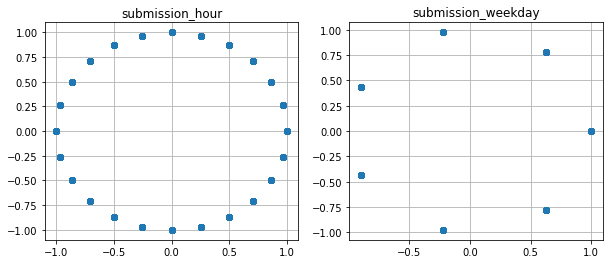

In [11]:
# Encoding the cyclic time features:
c_enc = CycleEncoder(period=24)
submission_hour_cos, submission_hour_sin = c_enc.transform(df_train['submission_hour'].values)
c_enc = CycleEncoder(period=7)
submission_weekday_cos, submission_weekday_sin = c_enc.transform(df_train['submission_weekday'].values)

df_train['submission_hour_cos'] = submission_hour_cos
df_train['submission_hour_sin'] = submission_hour_sin
df_train['submission_weekday_cos'] = submission_weekday_cos
df_train['submission_weekday_sin'] = submission_weekday_sin


plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.title('submission_hour')
plt.scatter(submission_hour_cos, submission_hour_sin, alpha=0.5, zorder=2)
plt.grid()
plt.subplot(1,2,2)
plt.title('submission_weekday')
plt.scatter(submission_weekday_cos, submission_weekday_sin, alpha=0.5, zorder=2)
plt.grid()
plt.show()

In [12]:
id_cols = ['id', 'reviewer_id', 'product_id', 'product_name']
boxplot_cols = df_train.describe().columns[~np.isin(df_train.describe().columns, id_cols)]
histogram_cols = ['reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
                  'product_brand',
                  'site_category_lv1', 'site_category_lv2', 'rating', 
                  'submission_hour', 'submission_weekday', 'submission_month', 'submission_year']

In [13]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,92661.0,46330.000000,26749.070984,0.000000,23165.000000,4.633000e+04,6.949500e+04,92660.000000
reviewer_birth_year,88510.0,1977.502655,23.072064,59.000000,1969.000000,1.980000e+03,1.987000e+03,2018.000000
rating,92661.0,3.488954,1.531467,1.000000,2.000000,4.000000e+00,5.000000e+00,5.000000
len_review_title,92661.0,18.801912,13.899987,1.000000,10.000000,1.600000e+01,2.300000e+01,150.000000
len_review_text,92661.0,142.158071,138.496313,50.000000,69.000000,9.700000e+01,1.600000e+02,4548.000000
submission_hour,92661.0,12.190112,5.074399,0.000000,8.000000,1.200000e+01,1.600000e+01,23.000000
submission_weekday,92661.0,2.738455,1.904045,0.000000,1.000000,3.000000e+00,4.000000e+00,6.000000
submission_month,92661.0,3.013630,1.468527,1.000000,1.000000,3.000000e+00,4.000000e+00,5.000000
submission_year,92661.0,2018.000000,0.000000,2018.000000,2018.000000,2.018000e+03,2.018000e+03,2018.000000
submission_hour_cos,92661.0,-0.334501,0.517426,-1.000000,-0.707107,-5.000000e-01,6.123234e-17,1.000000


In [14]:
for col in df_train.columns:
    value_counts = df_train[col].value_counts(dropna=False)
    print(col+' |', value_counts.shape[0], 'unique values |', df_train[col].isnull().sum(), 'nulls values')

id | 92661 unique values | 0 nulls values
submission_date | 91431 unique values | 0 nulls values
review_title | 41640 unique values | 0 nulls values
review_text | 91252 unique values | 0 nulls values
reviewer_id | 82211 unique values | 0 nulls values
reviewer_birth_year | 113 unique values | 4151 nulls values
reviewer_gender | 3 unique values | 2868 nulls values
reviewer_state | 28 unique values | 2763 nulls values
product_id | 36973 unique values | 0 nulls values
product_name | 36531 unique values | 58 nulls values
product_brand | 946 unique values | 64010 nulls values
site_category_lv1 | 54 unique values | 5 nulls values
site_category_lv2 | 683 unique values | 2817 nulls values
rating | 5 unique values | 0 nulls values
len_review_title | 149 unique values | 0 nulls values
len_review_text | 1123 unique values | 0 nulls values
submission_hour | 24 unique values | 0 nulls values
submission_weekday | 7 unique values | 0 nulls values
submission_month | 5 unique values | 0 nulls values
sub

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92661 entries, 0 to 92660
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      92661 non-null  int64         
 1   submission_date         92661 non-null  datetime64[ns]
 2   review_title            92661 non-null  object        
 3   review_text             92661 non-null  object        
 4   reviewer_id             92661 non-null  object        
 5   reviewer_birth_year     88510 non-null  float64       
 6   reviewer_gender         89793 non-null  object        
 7   reviewer_state          89898 non-null  object        
 8   product_id              92661 non-null  object        
 9   product_name            92603 non-null  object        
 10  product_brand           28651 non-null  object        
 11  site_category_lv1       92656 non-null  object        
 12  site_category_lv2       89844 non-null  object

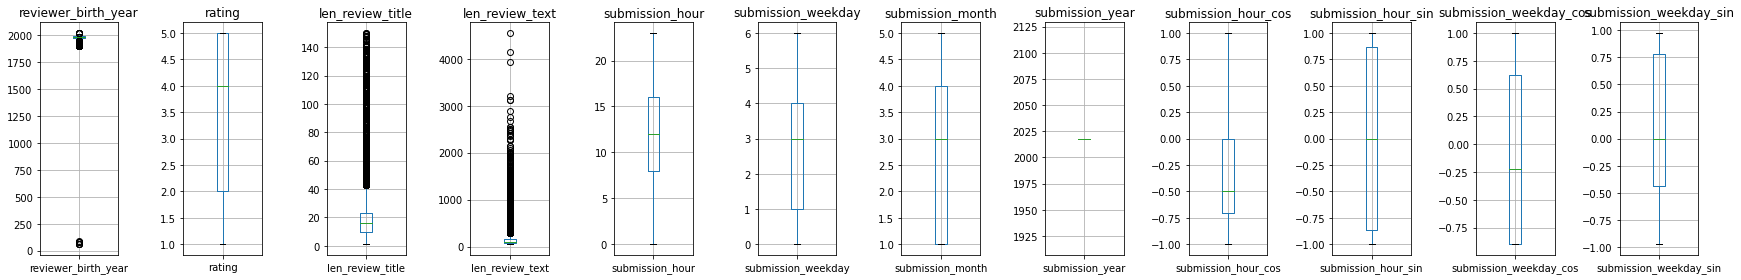

In [26]:
# Boxplots:
plot_feature_boxplots(df_train, boxplot_cols, figsize=(24, 4))

In [17]:
df_train['reviewer_gender'].isnull().sum()/df_train.shape[0]

0.03095153300741412

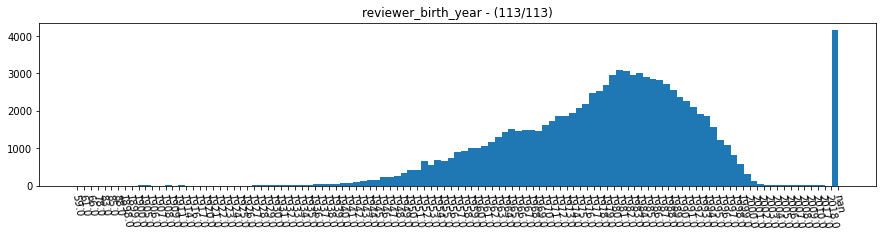

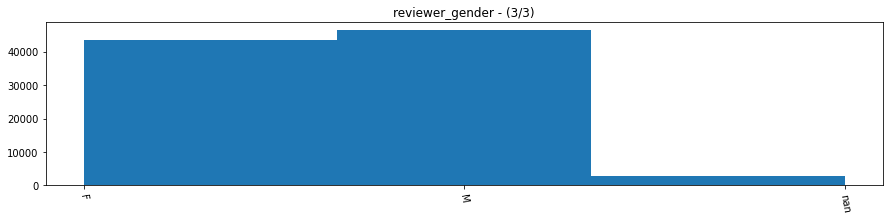

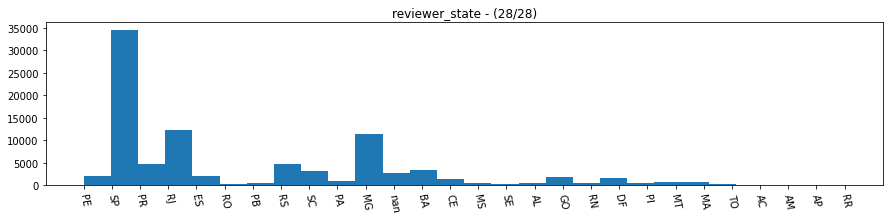

C:\Users\weldl\Google Drive\Kaggle\i2a2-nlp-2021-sentiment-analysis\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


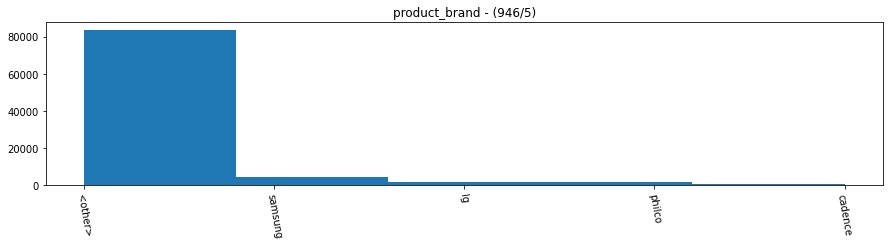

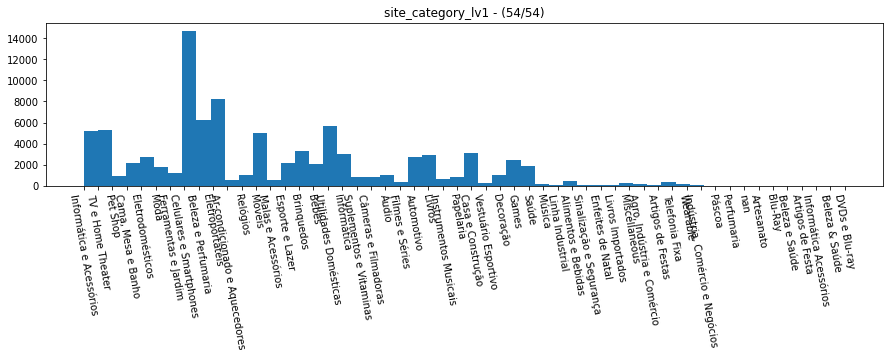

C:\Users\weldl\Google Drive\Kaggle\i2a2-nlp-2021-sentiment-analysis\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


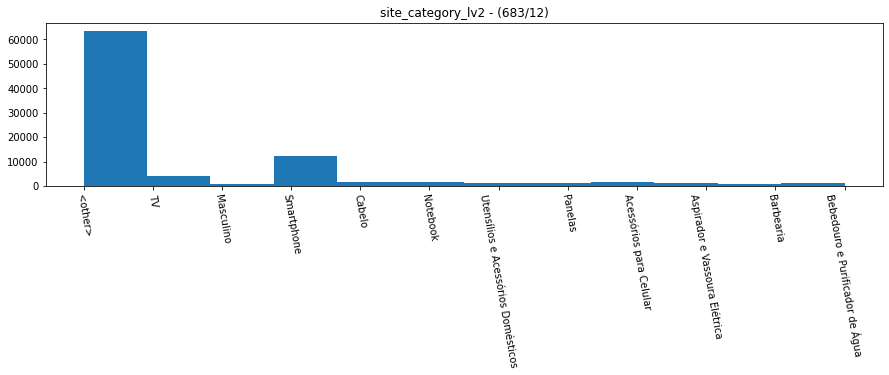

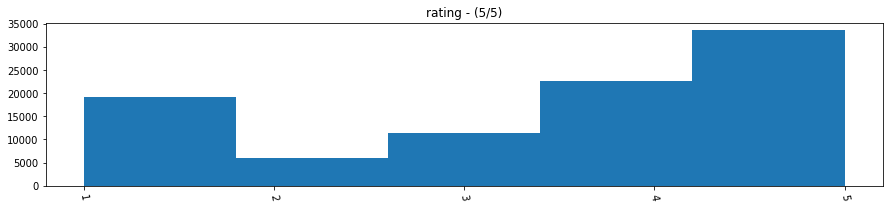

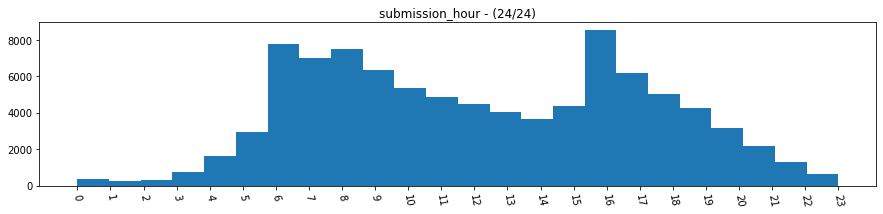

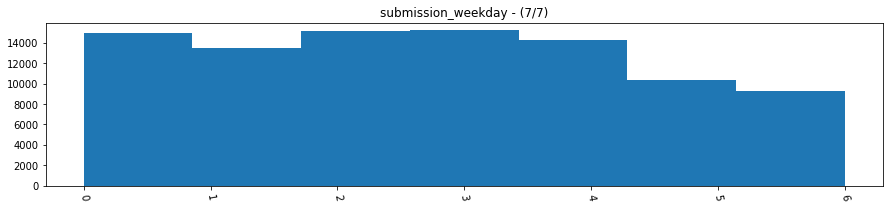

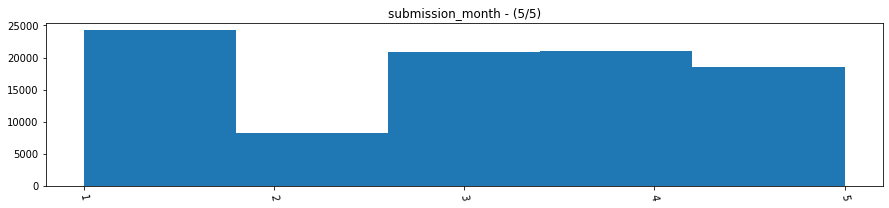

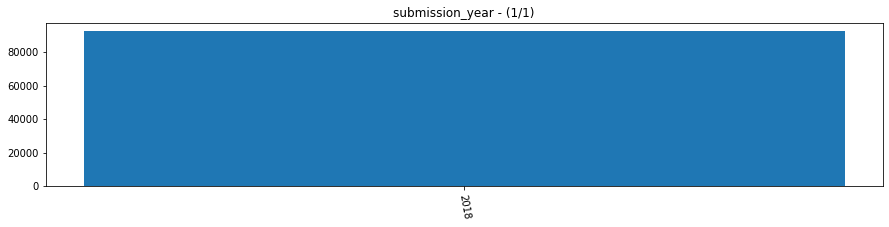

In [18]:
# Histogram:
plot_feature_histograms(df_train, histogram_cols, major_cat_perc=0.01)

In [19]:
df_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,39712.0,19855.500000,11464.011282,0.0,9927.75,19855.5,29783.25,39711.0
reviewer_birth_year,37879.0,1977.480108,18.861689,71.0,1969.00,1980.0,1987.00,2018.0
len_review_title,39712.0,18.824109,13.877416,1.0,10.00,16.0,23.00,148.0
len_review_text,39712.0,140.892854,133.636827,50.0,68.00,97.0,160.00,3924.0


In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39712 entries, 0 to 39711
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39712 non-null  int64  
 1   submission_date      39712 non-null  object 
 2   review_title         39712 non-null  object 
 3   review_text          39712 non-null  object 
 4   reviewer_id          39712 non-null  object 
 5   reviewer_birth_year  37879 non-null  float64
 6   reviewer_gender      38444 non-null  object 
 7   reviewer_state       38484 non-null  object 
 8   product_id           39712 non-null  object 
 9   product_name         39686 non-null  object 
 10  product_brand        12331 non-null  object 
 11  site_category_lv1    39711 non-null  object 
 12  site_category_lv2    38516 non-null  object 
 13  len_review_title     39712 non-null  int64  
 14  len_review_text      39712 non-null  int64  
dtypes: float64(1), int64(3), object(11)


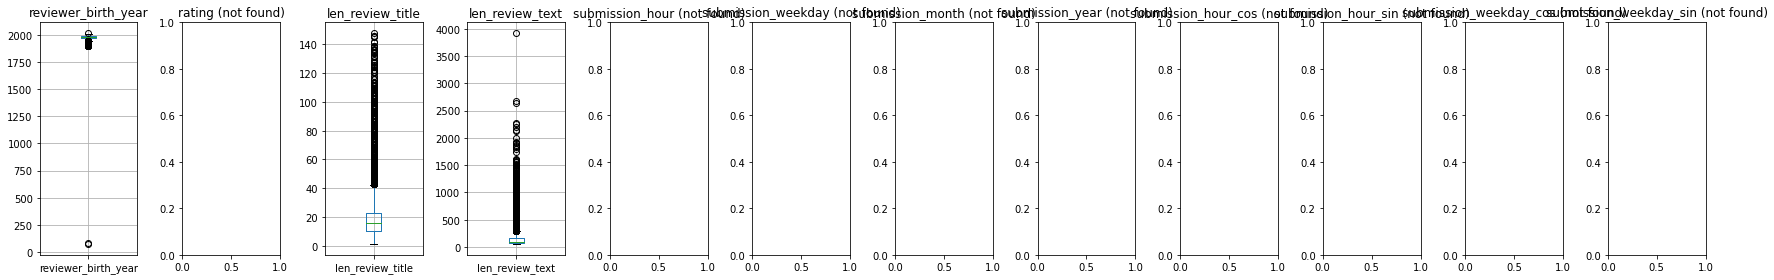

In [27]:
# Boxplots:
plot_feature_boxplots(df_test, boxplot_cols, figsize=(24, 4))

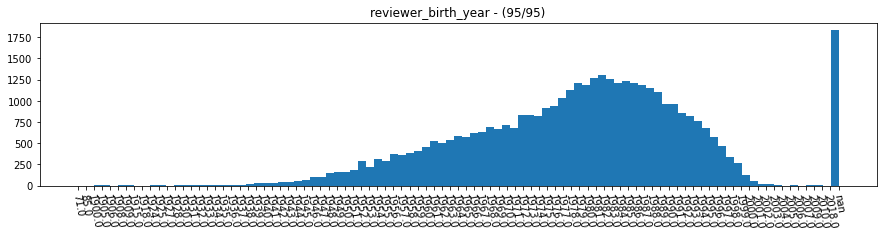

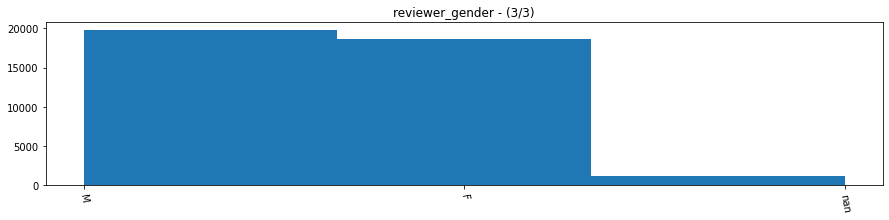

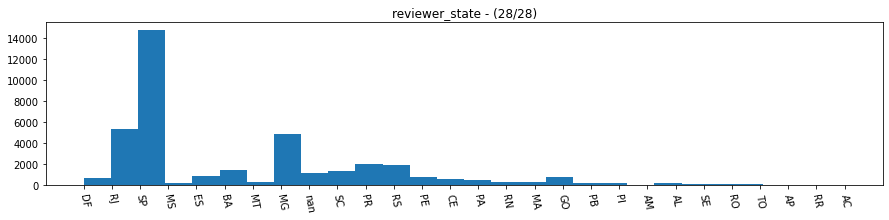

C:\Users\weldl\Google Drive\Kaggle\i2a2-nlp-2021-sentiment-analysis\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


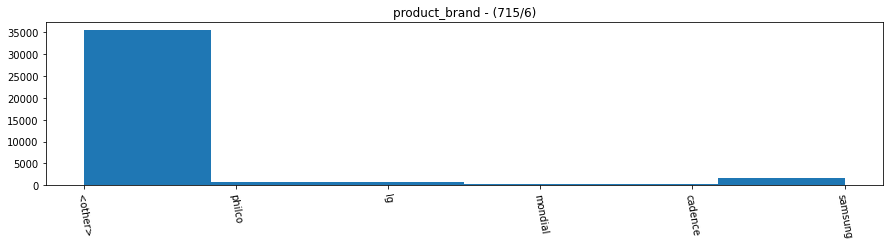

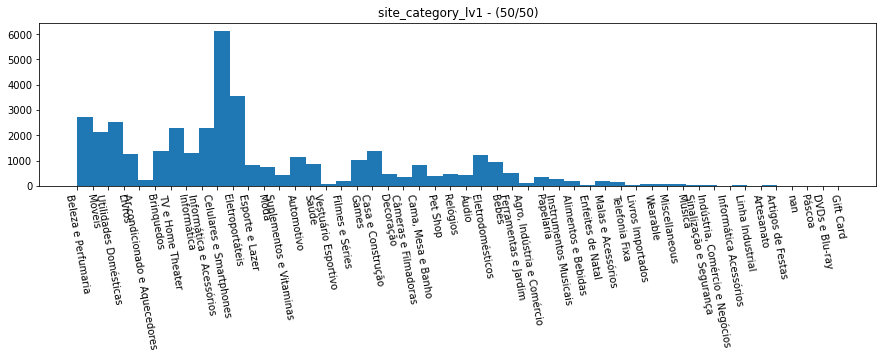

C:\Users\weldl\Google Drive\Kaggle\i2a2-nlp-2021-sentiment-analysis\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


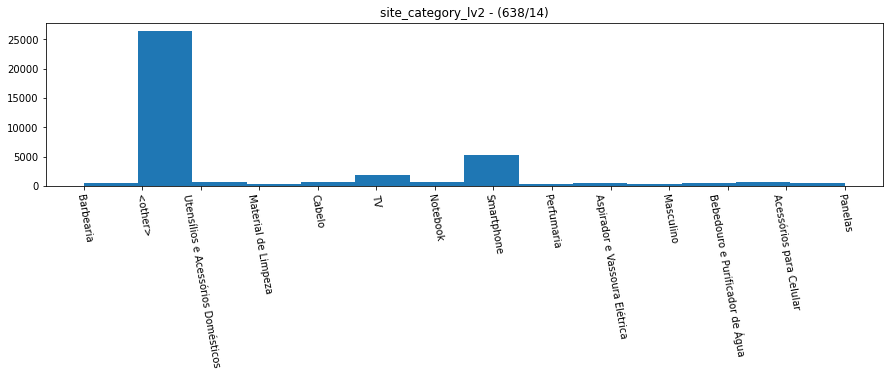

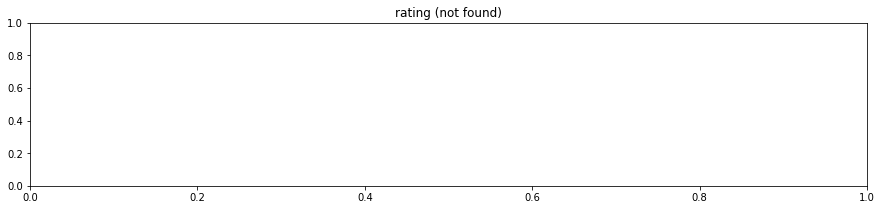

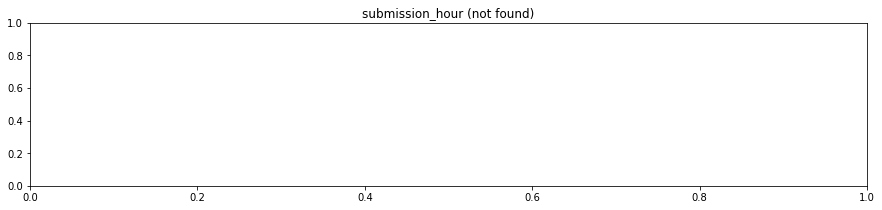

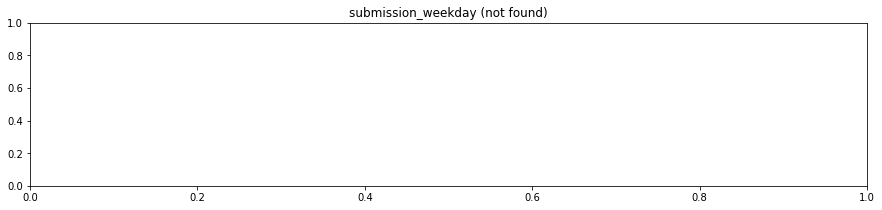

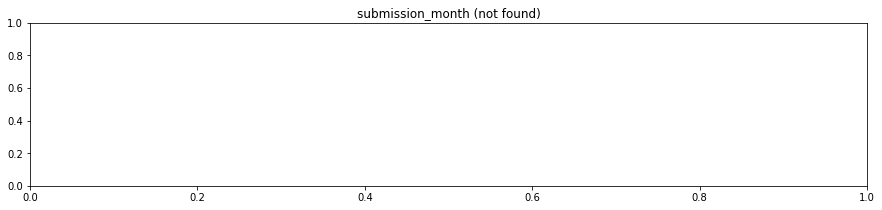

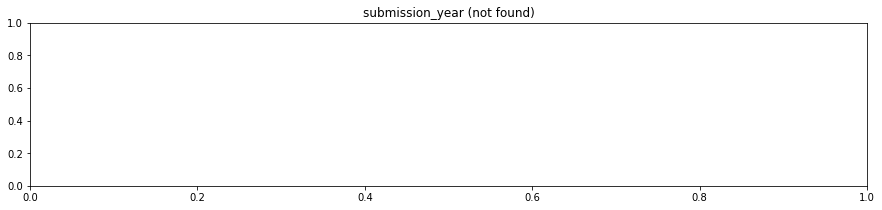

In [22]:
# Histogram:
plot_feature_histograms(df_test, histogram_cols, major_cat_perc=0.01)

# Submission file:

In [23]:
# Submission file:
sample_submission = pd.read_csv(os.path.join(dataset_folder, "sample_submission.csv"), low_memory=False)

In [24]:
sample_submission

,id,rating
0,0,2
1,1,4
2,2,3
3,3,3
4,4,3
...,...,...
39707,39707,2
39708,39708,2
39709,39709,2
39710,39710,3
